# Air quality impact on hives survival 

The dataset is from Nectar 1.19 and cover hives from 2020 to 2023. The 2023 season is currently censored in terms of winter mortality but you can analyse the acute effect (which I didn't include in the blog post but I did have a look at the effect on the summer mortality and the effect are even stronger). I also shared the complete daily history for all the yards in the dataset for air quality , ndvi and weather that was scrapped from Airpyllution package, meteostats package and earth engine. Finally, you will find a file called 'ops_meta.csv' which contains the region of the given operations. 

The file are found on this google drive: [here](https://drive.google.com/drive/u/0/folders/1UZ3_jzMRdaQEaIR1TzPqEWTb0azECStB)


***
### SETUP

In [1]:
import os 
import ast
from datetime import datetime, date,timezone, timedelta

import pandas as pd 
import numpy as np
from collections import Counter

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from pymer4.models import Lmer
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

NECTAR_PALETTE = "blend:#D8A348,#1D1D1D"
sns.set_palette(NECTAR_PALETTE)

ROOT_PATH = "../data"
SEASONS_INCLUDED = [2021, 2022, 2023]
FEATURES_MONTH = [6,7,8,9]
RUN_PREPROCESS = False

# Don't change these values 
START_SEASON_MONTH = 6
START_SEASON_DAY = 1
END_SEASON_MONTH = 10
END_SEASON_DAY = 1

In [2]:
from aqi.data.utils import timestamp_to_date, try_check_month
from aqi.vizualisation.utils import plot_survival_bar_per_state

***
### LOADING DATA

In [3]:
if RUN_PREPROCESS:
    operation_meta = pd.read_csv(os.path.join(ROOT_PATH,"ops_meta.csv"))
    aqi = pd.read_csv(os.path.join(ROOT_PATH,"aqi_dev.csv"))
    weather = pd.read_csv(os.path.join(ROOT_PATH,"weather_dev.csv"))
    ee = pd.read_csv(os.path.join(ROOT_PATH,"ee_dev.csv"))
    ee.drop("ee-image",axis=1,inplace=True)
    ee.dropna(subset=["ndvi"],inplace=True)
    
    mov = pd.read_csv(os.path.join(ROOT_PATH,"mouvements.csv"))

    data = pd.read_csv(os.path.join(ROOT_PATH,"merged_dev.csv"))
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))
data['death_date'] = pd.to_datetime(data['death_date'], format='mixed')
data = data.loc[data['season'].isin(SEASONS_INCLUDED)]

In [4]:
aqi.head()

,time,yard_id,pm2_5,pm10,o3,co,no,no2,so2,nh3,aqhi
0,2021-06-01,234,8.918750,11.846250,102.520833,199.229583,0.288750,5.368333,2.411667,4.642917,7
1,2021-06-01,270,8.918750,11.846250,102.520833,199.229583,0.288750,5.368333,2.411667,4.642917,7
2,2021-06-01,271,8.400417,12.664167,96.246667,195.056250,0.209167,3.560417,1.347917,4.574167,6
3,2021-06-01,272,8.400417,12.664167,96.246667,195.056250,0.209167,3.560417,1.347917,4.574167,6
4,2021-06-01,273,8.918750,11.846250,102.520833,199.229583,0.288750,5.368333,2.411667,4.642917,7


In [5]:
if RUN_PREPROCESS:
    weather.isnull().mean() # For some reason atmost pressure is not getting scrapped 

In [6]:
if RUN_PREPROCESS:
    aqi.isnull().mean()

In [7]:
if RUN_PREPROCESS:
    ee.isnull().mean() # 2023 is null , need to update for simulations later...

In [8]:
if RUN_PREPROCESS:
    ee.head()

In [9]:
if RUN_PREPROCESS:
    data['creation_date'] = pd.to_datetime(data['creation_date'],format='mixed').dt.date
    data['death_date']= pd.to_datetime(data['death_date']).dt.date

In [10]:
if RUN_PREPROCESS:
    Counter(data.hid.value_counts()) # Meaning that 16 632 hives are present in two season while 38405 are only in one season 

In [11]:
if RUN_PREPROCESS:
    ### Label creation (based on season start end)
    
    def get_state_for_season(state_log):
        return state_log.apply(lambda x : x['death_date'] != date(x['season']+1,START_SEASON_MONTH,START_SEASON_DAY), axis=1)
    
    def get_age_for_season(state_log):
        return state_log.apply(lambda x : abs((x['death_date'] - x['creation_date']).days), axis=1)
    
    
    data['death_next_season'] = get_state_for_season(data)
    data['hive_age_next_season'] = get_age_for_season(data)

In [12]:
data['death_next_season'].mean()

0.21521898967278025

In [13]:
data.dtypes

hid                      int64
creation_date           object
operation_id             int64
death_date              object
season                   int64
death_next_season         bool
hive_age_next_season     int64
dtype: object

In [14]:
data.operation_id.value_counts()

operation_id
193    44996
69     33202
153    18265
55     14186
167    10597
161     8221
87      5841
207     5607
210     1720
195     1588
36      1084
194      789
212      741
219      397
160      322
159      228
205      193
83       188
220       82
199        2
Name: count, dtype: int64

In [15]:
data.season.value_counts()

season
2023    107172
2022     32164
2021      8913
Name: count, dtype: int64

In [16]:
data.drop(['death_date','creation_date'],axis=1).groupby(['season','operation_id']).mean(numeric_only=True)[['death_next_season','hive_age_next_season']]

death_next_season  hive_age_next_season
season operation_id                                         
2021   36                     0.034884            374.296512
       55                     0.631184            319.231549
       69                     0.653664            345.589835
       83                     0.000000            308.000000
       87                     0.868106            233.582734
2022   36                     0.307978            509.821892
       55                     0.238085            551.987305
       69                     0.338473            357.186206
       83                     0.552632            393.394737
       87                     0.566813            404.662103
       153                    0.408203            381.321779
       159                    0.706897            292.086207
       160                    0.275862            343.672414
       161                    0.326817            263.603543
       167                    0.950954            343.819255
2023   36                     0.000000            913.525469
       55                     0.049328            734.802267
       69                     0.138861            509.819924
       83                     0.055556            822.444444
       87                     0.171852            448.547395
       153                    0.045369            573.771176
       159                    0.035714            461.142857
       160                    0.063107            558.873786
       161                    0.029715            501.978775
       167                    0.137848            337.949031
       193                    0.154325            421.237221
       194                    0.048162            318.356147
       195                    0.034005            315.068010
       199                    0.000000            423.500000
       205                    0.000000            356.248705
       207                    0.227751            271.232388
       210                    0.070349            313.478488
       212                    0.331984            225.112011
       219                    0.007557            251.350126
       220                    0.000000            256.000000

In [17]:
if RUN_PREPROCESS:
    # BAD OPS in 2021-2022
    data = data.loc[~data['operation_id'].isin([51,167,84])]

In [18]:
len(data)

137652

In [19]:
data.isnull().mean()

hid                     0.0
creation_date           0.0
operation_id            0.0
death_date              0.0
season                  0.0
death_next_season       0.0
hive_age_next_season    0.0
dtype: float64

### Feature eng for predictive models


### From mouvements to sensors data 

- Idea is to get the location of the hive at time X between june 1st and August 31 
- Once we have that info we simply do statistic on the sequence 


***
### One hive example

In [20]:
if RUN_PREPROCESS:
    mov['to_when'].fillna(date.today(),inplace=True) # When null still didn't moved
    mov['from_when'] = pd.to_datetime(mov['from_when'],format='mixed').dt.date
    mov['to_when'] = pd.to_datetime(mov['to_when'],format='mixed').dt.date
    
    aqi['time'] = pd.to_datetime(aqi['time'],format='mixed').dt.date
    weather['time'] = pd.to_datetime(weather['time'],format='mixed').dt.date
    ee['time'] = pd.to_datetime(ee['time'],format='mixed').dt.date

In [21]:
if RUN_PREPROCESS:
    # Only keep aqi, weather and ee for summer month 
    
    aqi = aqi.loc[pd.to_datetime(aqi['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    weather = weather.loc[pd.to_datetime(weather['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    ee = ee.loc[pd.to_datetime(ee['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [22]:
if RUN_PREPROCESS:
    one = mov.loc[mov['hive_identity_id']==21199]

In [23]:
if RUN_PREPROCESS:
    one = (one.assign(time = [pd.date_range(start, end) 
                       for start, end 
                       in zip(one['from_when'], one['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [24]:
if RUN_PREPROCESS:
    one['time'] = pd.to_datetime(one['time']).dt.date

In [25]:
if RUN_PREPROCESS:
    one.head()

In [26]:
if RUN_PREPROCESS:
    one = pd.merge(one,aqi, on=["yard_id","time"])

In [27]:
if RUN_PREPROCESS:
    one['season'] = pd.to_datetime(one['time']).dt.year
    one['month'] = pd.to_datetime(one['time']).dt.month

In [28]:
if RUN_PREPROCESS:
    one[['season','month','aqhi']].groupby(["season","month"]).mean()

### ALL hives and sensors

In [29]:
if RUN_PREPROCESS:
    mov = mov[mov['hive_identity_id'].isin(list(data.hid.unique()))].reset_index(drop=True)

In [30]:
if RUN_PREPROCESS:
    # WARNING THIS TAKES A WHILE (5 minutes...or so)
    mov = (mov.assign(time = [pd.date_range(start,end) 
                       for start, end 
                       in zip(mov['from_when'], mov['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [31]:
if RUN_PREPROCESS:
    mov['time'] = pd.to_datetime(mov['time']).dt.date
    
    mov = mov.loc[pd.to_datetime(mov['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [32]:
if RUN_PREPROCESS:
    merged = pd.merge(mov,aqi, on=["yard_id","time"])
    merged = pd.merge(merged,weather, on=["yard_id","time"])
    merged = pd.merge(merged,ee, on=["yard_id","time"])
    
    merged.head()

In [33]:
if RUN_PREPROCESS:
    merged.isnull().mean()

### TSun and Wdir high null, just ignore them 

In [34]:
if RUN_PREPROCESS:
    merged.drop(['tsun','wdir'],axis=1,inplace=True)

### Compute stats for each hid

In [35]:
if RUN_PREPROCESS:
    merged['season'] = pd.to_datetime(merged['time']).dt.year

In [36]:
if RUN_PREPROCESS:
    # THis takes 10 min or so locally
    averages = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).mean().reset_index()
    skewed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).agg(lambda x : skew(x)).reset_index()
    maxed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).max().reset_index()

In [37]:
if RUN_PREPROCESS:
    averages.rename(columns={"aqhi":"aqhi_average","prcp":"prcp_average","wspd":"wspd_average","ndvi":"ndvi_average"
                             ,"tavg":"tavg_average","o3":"o3_average","hive_identity_id":"hid"},inplace=True)
    skewed.rename(columns={"aqhi":"aqhi_skew","prcp":"prcp_skew","wspd":"wspd_skew","ndvi":"ndvi_skew"
                           ,"tavg":"tavg_skew","o3":"o3_skew","hive_identity_id":"hid"},inplace=True)
    maxed.rename(columns={"aqhi":"aqhi_max","prcp":"prcp_max","wspd":"wspd_max","ndvi":"ndvi_max"
                          ,"tavg":"tavg_max","o3":"o3_max","hive_identity_id":"hid"},inplace=True)


### Bring remote sensors with season state (merge)

In [38]:
if RUN_PREPROCESS:
    print(len(data))
    data = pd.merge(data, averages[['season','hid','aqhi_average','prcp_average','wspd_average'
                                    ,'ndvi_average','tavg_average','o3_average']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, skewed[['season','hid','aqhi_skew','prcp_skew','wspd_skew'
                                  ,'ndvi_skew','tavg_skew','o3_skew']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, maxed[['season','hid','aqhi_max','prcp_max','wspd_max'
                                 ,'ndvi_max','tavg_max','o3_max']], on=["season","hid"], how="left")
    print(len(data))

137652
137652
137652
137652


In [39]:
data.head()

,hid,creation_date,operation_id,death_date,season,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,...,wspd_skew,ndvi_skew,tavg_skew,o3_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max,o3_max
0,21199,2021-06-23,55,2022-06-01,2021,False,343,2.0,0.1,5.20,...,3.252607e-15,0.000000e+00,0.0,-2.087878e-15,2.0,0.2,5.6,0.643625,20.4,36.463333
1,38198,2021-09-27,55,2022-06-01,2021,False,247,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22571,2021-07-28,83,2022-06-01,2021,False,308,3.0,0.0,4.80,...,NaN,NaN,NaN,NaN,3.0,0.0,4.8,0.336577,16.4,29.482500
3,19339,2021-06-18,69,2022-06-01,2021,False,348,5.0,0.0,11.95,...,2.408966e-15,4.442735e-16,0.0,0.000000e+00,6.0,0.0,13.1,0.501838,25.5,92.327917
4,19340,2021-06-18,69,2022-06-01,2021,False,348,5.0,0.0,11.95,...,2.408966e-15,4.442735e-16,0.0,0.000000e+00,6.0,0.0,13.1,0.501838,25.5,92.327917


In [40]:
len(data)

137652

### Add region

In [41]:
if RUN_PREPROCESS:
    operation_meta.index = operation_meta['Operation ID']
    regions = operation_meta.to_dict(orient="dict")['Location']

In [42]:
def try_region(x):
    try:
        return regions[str(x)].split(",")[1]
    except:
        return 'Unknown'

In [43]:
if RUN_PREPROCESS:
    data['region'] = data['operation_id'].apply(lambda x: try_region(x))
data['region'].value_counts()

region
 AB        57501
 CA        46584
 QC        24127
 FL         5607
 WA         1084
Unknown      895
 WY          789
 NY          741
 NS          322
 KS            2
Name: count, dtype: int64

### Saving preprocess so we don't need to run every time

In [44]:
if RUN_PREPROCESS:
    data.to_csv(os.path.join(ROOT_PATH,"preprocess.csv"),index=False)
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [45]:
len(data)

137652

In [46]:
ONLY_WINTER = False
ONLY_INSEASON = False 
ACTIVE_ALL_AND_WINTER = True  # Blog post hypothesis 
if ONLY_WINTER or ONLY_INSEASON:
    assert ONLY_WINTER != ONLY_INSEASON, "choose one! or both False"
if ONLY_INSEASON or ACTIVE_ALL_AND_WINTER:
    assert ACTIVE_ALL_AND_WINTER != ONLY_INSEASON, "choose one! or both False"

# Reload and apply
data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [47]:
len(data)

137652

In [48]:
if ONLY_WINTER:
    # Exclude in-season deadout , we are just looking at winter morta 
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'] > date(int(x['season']),END_SEASON_MONTH,END_SEASON_DAY),axis=1)
    data = data.loc[data['winter_deadout']].reset_index(drop=True)

if ONLY_INSEASON:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'].month in [6,7,8],axis=1)
    data = data.loc[~data['winter_deadout'] | ~data['death_next_season']].reset_index(drop=True)

if ACTIVE_ALL_AND_WINTER:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['creation_date'] = pd.to_datetime(data['creation_date']).dt.date
    # This ensure the exposition rate is the full season (makes them comparable with the current approach)
    data = data.loc[(data['creation_date'] <= data['season'].apply(lambda x: date(int(x),START_SEASON_MONTH+1,START_SEASON_DAY))) \
            & (data['death_date'] > data['season'].apply(lambda x : date(int(x),END_SEASON_MONTH,END_SEASON_DAY)))]
    data = data.reset_index(drop=True)


### Keep next year aside and exclude some abnormal data

In [49]:
next_year = data.loc[data['season']==2023].reset_index(drop=True)
if not ONLY_INSEASON:
    data = data.loc[data['season']!=2023].reset_index(drop=True)

In [50]:
len(data)

30439

In [51]:
data.groupby(["death_next_season","season"]).mean(numeric_only=True)

hid  operation_id  hive_age_next_season  \
death_next_season season                                                     
False             2021    17142.420027     59.155415            367.472587   
                  2022    53375.674205     97.692630            445.451785   
True              2021    17087.594645     61.198126            343.560107   
                  2022    52545.046219    108.259505            401.855548   

                          aqhi_average  prcp_average  wspd_average  \
death_next_season season                                             
False             2021        3.488521      0.380909     11.049879   
                  2022        2.984821      1.038794     10.807450   
True              2021        3.333512      0.361834     11.488884   
                  2022        2.819238      0.766829     10.386509   

                          ndvi_average  tavg_average  o3_average  aqhi_skew  \
death_next_season season                                                      
False             2021        0.424834     19.871530   57.067167   0.294449   
                  2022        0.452435     17.207498   47.831912  -0.188264   
True              2021        0.459772     19.610112   55.381465   0.268403   
                  2022        0.398924     16.992298   46.520495  -0.256405   

                          ...  wspd_skew  ndvi_skew  tavg_skew   o3_skew  \
death_next_season season  ...                                              
False             2021    ...   0.198110   0.097643   0.015265  0.310174   
                  2022    ...   0.052575  -0.339672  -0.122884 -0.115858   
True              2021    ...   0.143533   0.068253   0.027405  0.320726   
                  2022    ...   0.108917  -0.340827  -0.081071 -0.129775   

                          aqhi_max  prcp_max   wspd_max  ndvi_max   tavg_max  \
death_next_season season                                                       
False             2021    4.651110  0.882102  13.823108  0.512187  21.364341   
                  2022    3.463862  2.494184  13.428847  0.571514  20.980325   
True              2021    4.331459  0.888434  14.527175  0.541029  21.165114   
                  2022    3.228815  1.852193  13.680837  0.538159  21.125238   

                             o3_max  
death_next_season season             
False             2021    72.134955  
                  2022    56.102385  
True              2021    68.785118  
                  2022    53.919444  

[4 rows x 21 columns]

In [52]:
data.season.value_counts()

season
2022    24497
2021     5942
Name: count, dtype: int64

In [53]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.005618
prcp_average            0.005618
wspd_average            0.005618
ndvi_average            0.005618
tavg_average            0.005618
o3_average              0.005618
aqhi_skew               0.199744
prcp_skew               0.376294
wspd_skew               0.015901
ndvi_skew               0.007260
tavg_skew               0.015572
o3_skew                 0.007260
aqhi_max                0.005618
prcp_max                0.005618
wspd_max                0.005618
ndvi_max                0.005618
tavg_max                0.005618
o3_max                  0.005618
region                  0.000000
dtype: float64

*** 
### Quick viz 

Just checking a bit the data for intuition

### Check different sensors bar chart

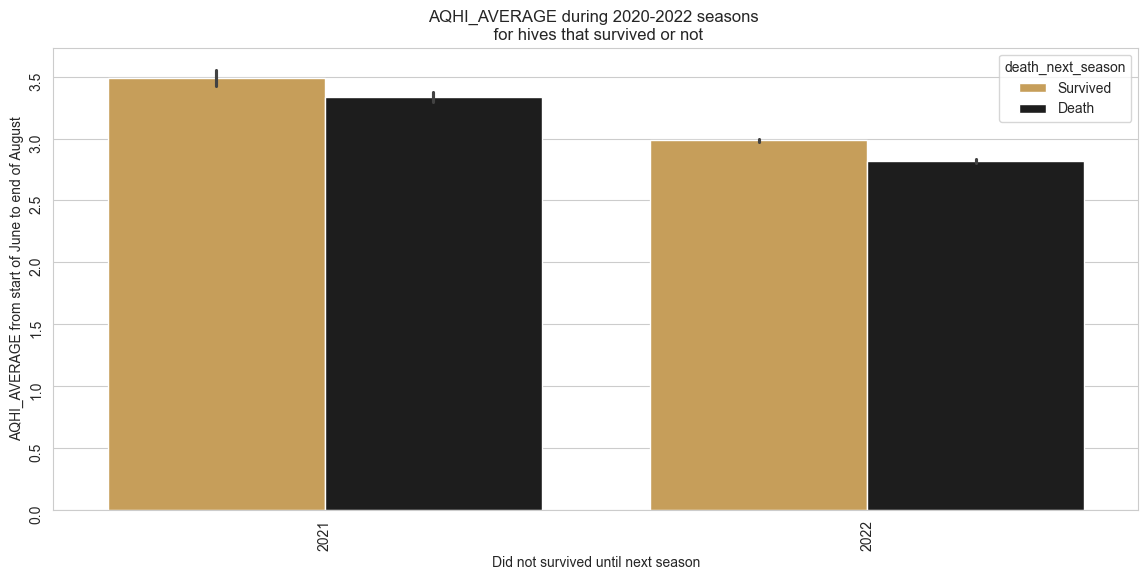

In [54]:
plot_survival_bar_per_state(data, "aqhi_average") # Bias by region for sure

### Check relation NDVI ~ AQHI


Idea is that increased vegetation should lead to less extreme AQHI value

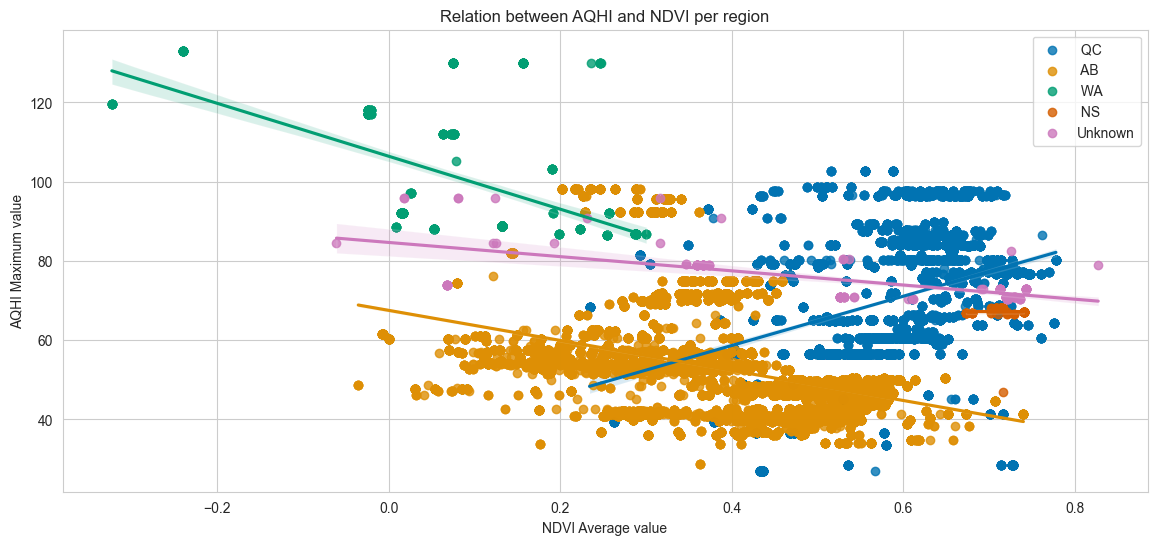

In [55]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["o3_max"], label=s, ax=ax)
plt.ylabel("AQHI Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between AQHI and NDVI per region")
plt.legend()
plt.show()

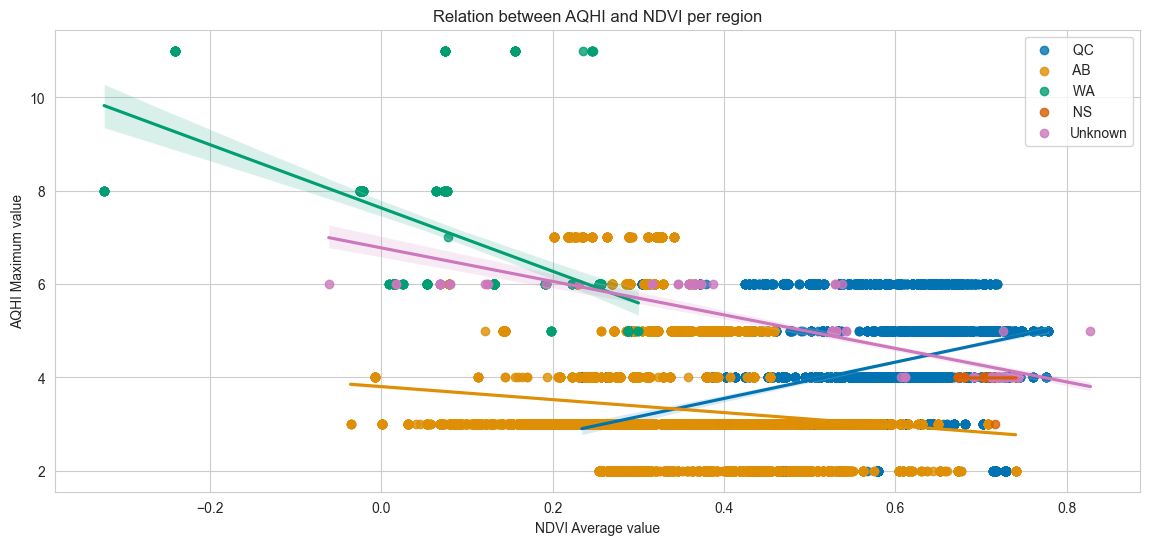

In [56]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["aqhi_max"], label=s, ax=ax)
plt.ylabel("AQHI Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between AQHI and NDVI per region")
plt.legend()
plt.show()

In [ ]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["aqhi_skew"], label=s, ax=ax)
plt.ylabel("AQHI Skewness value")
plt.xlabel("NDVI Average value")
plt.title("Relation between AQHI and NDVI per region")
plt.legend()
plt.show()

### Check raw AQHI ~ mortality

Pattern for Quebec are different from the rest of the dataset

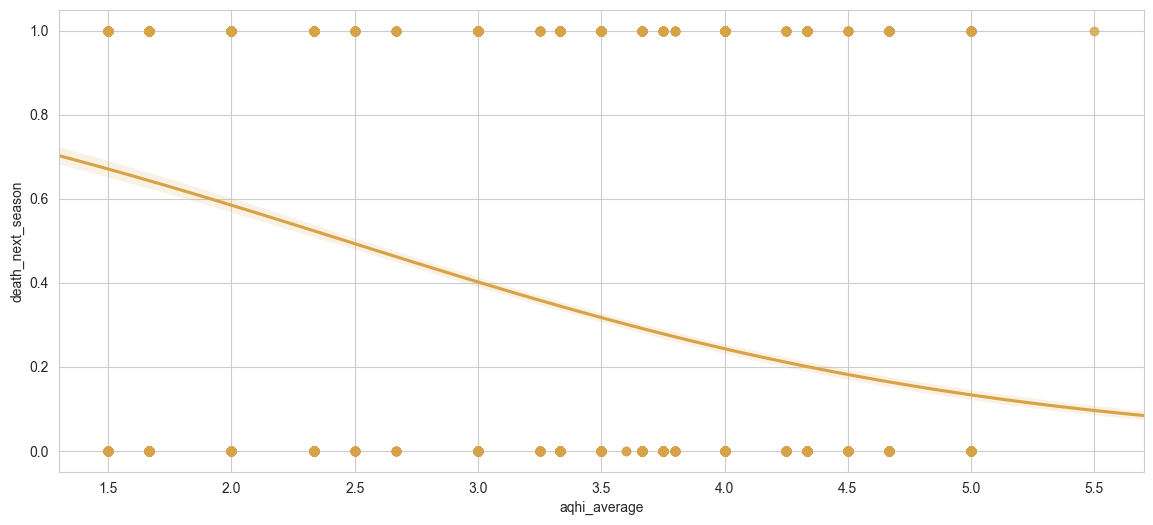

In [57]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']==" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

# This is starnge and may be due to hive located norther have faced more heavy aqhi ?

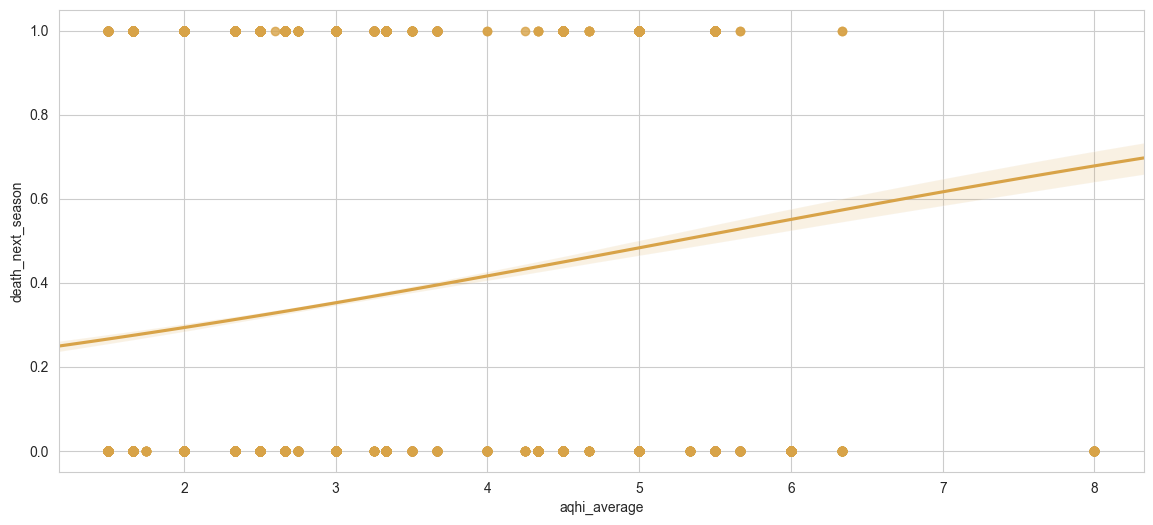

In [58]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']!=" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

*** 
### Check per region

In [59]:
data.region.value_counts()

region
 AB        21661
 QC         8021
 WA          519
Unknown      146
 NS           92
Name: count, dtype: int64

In [60]:
data.groupby("region").mean(numeric_only=True)

,hid,operation_id,season,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,ndvi_average,tavg_average,...,wspd_skew,ndvi_skew,tavg_skew,o3_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max,o3_max
region,,,,,,,,,,,,,,,,,,,,,
AB,52117.902590,100.687180,2021.882831,0.356909,394.927612,2.877181,0.772855,11.128865,0.390084,17.393223,...,0.085542,-0.352426,-0.049906,-0.177432,3.259440,1.856207,14.341998,0.532196,21.145575,52.720897
NS,57235.956522,160.000000,2022.000000,0.228261,379.467391,3.157609,5.177536,10.913225,0.717846,14.235145,...,0.611229,0.211670,-0.256701,0.438133,3.989130,14.518478,16.040217,0.733306,18.540217,67.213107
QC,30581.489964,73.963970,2021.596684,0.371525,472.692806,3.250004,1.010589,10.040174,0.588826,17.912207,...,0.093037,-0.048469,-0.177112,0.334437,4.283740,2.418007,11.869741,0.636046,20.459211,70.381592
WA,29417.398844,36.000000,2021.674374,0.007707,504.603083,5.464997,0.327778,9.770713,0.091410,24.016185,...,0.015437,0.291424,-0.091928,0.140804,7.011561,0.545472,12.650867,0.257972,26.821773,100.292501
Unknown,58694.027397,132.972603,2022.000000,0.506849,378.095890,4.080969,1.389243,9.530201,0.531999,20.505437,...,-0.115486,0.080857,-0.351350,0.095159,4.865248,3.818440,10.824823,0.586602,23.363121,75.126540


In [61]:
data = data.loc[data['region']!=' CA']
data.region.value_counts()

region
 AB        21661
 QC         8021
 WA          519
Unknown      146
 NS           92
Name: count, dtype: int64

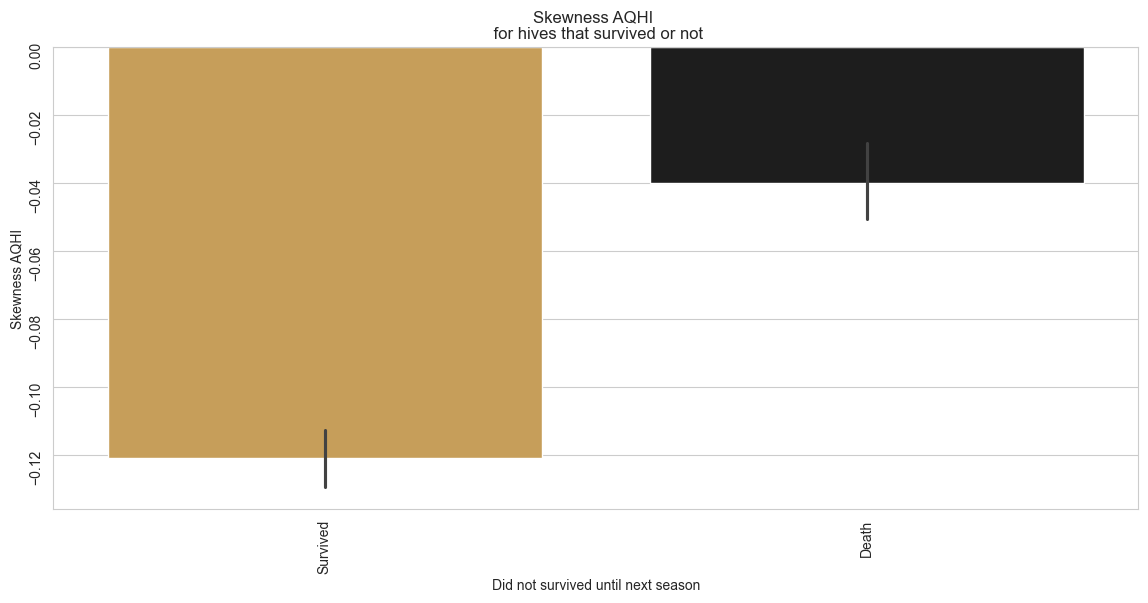

In [118]:
sns.set_style("whitegrid")
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax = sns.barplot(
    y=data['aqhi_skew'],x=data["death_next_season"].apply(lambda x : "Death" if x == 1 else "Survived"), ax=axes,
    palette="blend:#D8A348,#1D1D1D"#, errcolor="darkred"
)
#  
ax.set_ylabel("Skewness AQHI")
ax.set_xlabel("Did not survived until next season")
ax.tick_params(labelrotation=90)
plt.title("Skewness AQHI \n for hives that survived or not")
plt.show()

***
### DESCRIPTIVE STATS

In [63]:
data[['aqhi_average','ndvi_average']].isnull().mean()

aqhi_average    0.005618
ndvi_average    0.005618
dtype: float64

In [64]:
data.dropna(subset=['aqhi_average','ndvi_average'],axis=0,inplace=True) # Filling null value with zero

data['operation_id'] = data['operation_id'].astype(str)
data['season'] = data['season'].astype(str)

In [65]:
len(data)

30268

### Models 

In [ ]:
data.fillna(data.mean(numeric_only=True),inplace=True)

In [66]:
data['wspd_average_og'] = data['wspd_average']
data['tavg_average_og'] = data['tavg_average']
data['prcp_average_og'] = data['prcp_average']
data['aqhi_average_og'] = data['aqhi_average']

data['wspd_average'] = np.log(data['wspd_average']+10e-5)
data['tavg_average'] = np.log(data['tavg_average']+10e-5)
data['prcp_average'] = np.log(data['prcp_average']+10e-5)
data['aqhi_average'] = np.log(data['aqhi_average']+10e-5)

<Axes: xlabel='aqhi_max', ylabel='Count'>

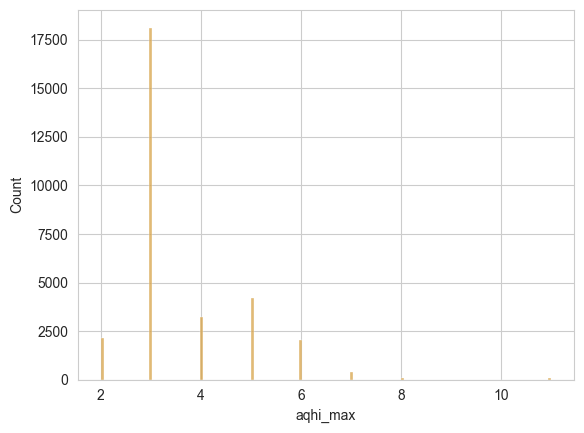

In [67]:
sns.histplot(data['aqhi_max'])

<Axes: xlabel='aqhi_average', ylabel='Count'>

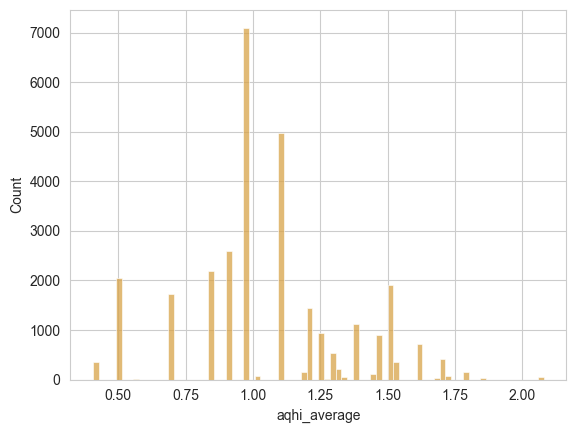

In [68]:
sns.histplot(data['aqhi_average'])

<Axes: xlabel='ndvi_average', ylabel='Count'>

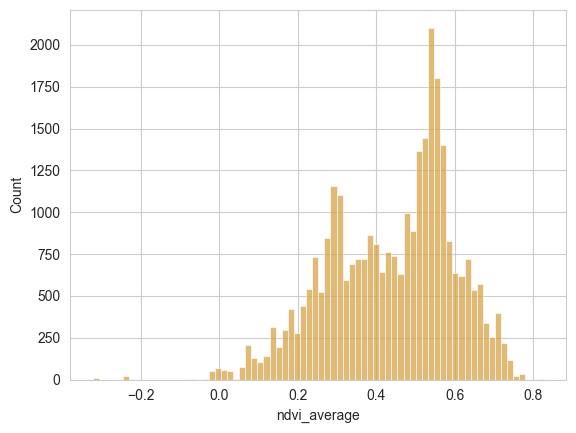

In [69]:
sns.histplot(data['ndvi_average'])

<Axes: xlabel='wspd_average', ylabel='Count'>

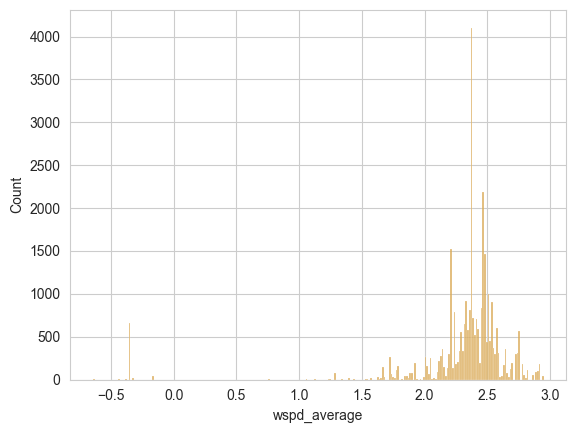

In [70]:
sns.histplot(data['wspd_average'])

In [71]:
data.death_next_season.mean()

0.3561517113783534

In [137]:
data.isnull().mean()

hid                     0.0
creation_date           0.0
operation_id            0.0
death_date              0.0
season                  0.0
death_next_season       0.0
hive_age_next_season    0.0
aqhi_average            0.0
prcp_average            0.0
wspd_average            0.0
ndvi_average            0.0
tavg_average            0.0
o3_average              0.0
aqhi_skew               0.0
prcp_skew               0.0
wspd_skew               0.0
ndvi_skew               0.0
tavg_skew               0.0
o3_skew                 0.0
aqhi_max                0.0
prcp_max                0.0
wspd_max                0.0
ndvi_max                0.0
tavg_max                0.0
o3_max                  0.0
region                  0.0
wspd_average_og         0.0
tavg_average_og         0.0
prcp_average_og         0.0
aqhi_average_og         0.0
dtype: float64

In [138]:
model0 = Lmer("death_next_season  ~ 1 + (1|region)",
             data=data, family = 'binomial')

print(model0.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~1+(1|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -19505.096 	 AIC: 39014.192

Random effects:

               Name    Var    Std
region  (Intercept)  2.897  1.702

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -1.413  -2.313   -0.514  0.459  0.243      0.099       0.598   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val Sig  
(Intercept)  0.196         0.09         0.374   -3.08  0.002  **  


In [139]:
model = Lmer("death_next_season  ~  aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18549.058 	 AIC: 37112.116

Random effects:

                Name     Var    Std
region   (Intercept)  16.677  4.084
region  aqhi_average   3.756  1.938

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.885

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                   0.595  -2.976    4.166  1.822  1.812      0.051   
aqhi_average                 -0.967  -2.840    0.907  0.956  0.380      0.058   
ndvi_average                 -2.344  -3.310   -1.378  0.493  0.096      0.037   
aqhi_average:ndvi_average     0.483  -0.453    1.418  0.477  1.620      0.636   

                           OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  \
(Intercept)       

In [140]:
model2 = Lmer("death_next_season  ~ aqhi_average + ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model2.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18549.536 	 AIC: 37111.072

Random effects:

                Name     Var    Std
region   (Intercept)  16.508  4.063
region  aqhi_average   3.770  1.942

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.876

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)      0.494  -2.842    3.830  1.702  1.639      0.058      46.062   
aqhi_average    -0.842  -2.606    0.922  0.900  0.431      0.074       2.515   
ndvi_average    -1.856  -2.063   -1.650  0.105  0.156      0.127       0.192   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.621        0.055         0.979   0.290  0.772       
aqhi_average  0.301        0.069        

In [141]:
model3 = Lmer("death_next_season  ~ aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model3.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18549.058 	 AIC: 37112.116

Random effects:

                Name     Var    Std
region   (Intercept)  16.677  4.084
region  aqhi_average   3.756  1.938

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.885

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                   0.595  -2.976    4.166  1.822  1.812      0.051   
aqhi_average                 -0.967  -2.840    0.907  0.956  0.380      0.058   
ndvi_average                 -2.344  -3.310   -1.378  0.493  0.096      0.037   
aqhi_average:ndvi_average     0.483  -0.453    1.418  0.477  1.620      0.636   

                           OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  \
(Intercept)       

In [142]:
model4 = Lmer("death_next_season  ~ aqhi_average + ndvi_average + tavg_average + prcp_average + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model4.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+tavg_average+prcp_average+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18463.839 	 AIC: 36945.678

Random effects:

                Name     Var    Std
region   (Intercept)  15.700  3.962
region  aqhi_average   3.194  1.787

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.881

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -3.580  -6.770   -0.390  1.627  0.028      0.001       0.677   
aqhi_average    -1.287  -2.920    0.345  0.833  0.276      0.054       1.411   
ndvi_average    -1.138  -1.393   -0.883  0.130  0.320      0.248       0.413   
tavg_average     1.576   1.277    1.875  0.153  4.834      3.584       6.520   
prcp_average    -0.011  -0.019   -0.003  0.004  0.989      0

In [143]:
model5 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average + tavg_average + prcp_average   + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model5.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+tavg_average+prcp_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18456.662 	 AIC: 36933.323

Random effects:

                Name     Var    Std
region   (Intercept)  14.497  3.808
region  aqhi_average   2.679  1.637

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.882

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                  -1.184  -4.989    2.622  1.942  0.306      0.007   
aqhi_average                 -3.152  -5.078   -1.225  0.983  0.043      0.006   
wspd_average                 -1.015  -1.452   -0.577  0.223  0.363      0.234   
ndvi_average                 -1.168  -1.424   -0.912  0.130  0.311      0.241   
tavg_average                  1.410   1.099    1.721  0

In [144]:
model6 = Lmer("death_next_season  ~ aqhi_average*wspd_average*tavg_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model6.fit())

Model failed to converge with max|grad| = 0.01291 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average*tavg_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18383.617 	 AIC: 36789.234

Random effects:

                Name    Var    Std
region   (Intercept)  4.436  2.106
region  aqhi_average  1.548  1.244

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.639

Fixed effects:

                                        Estimate   2.5_ci  97.5_ci     SE  \
(Intercept)                             -143.771 -146.137 -141.406  1.207   
aqhi_average                             128.361  125.904  130.818  1.254   
wspd_average                              59.398   58.074   60.722  0.676   
tavg_average                              49.658   48.609   50.708  0.535   
aqhi_average:wspd_average

In [145]:
model7a = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average  + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model7a.fit())

Model failed to converge with max|grad| = 0.00658436 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average*wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18606.482 	 AIC: 37234.964

Random effects:

                Name    Var    Std
region   (Intercept)  5.847  2.418
region  ndvi_average  1.615  1.271

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.643

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                2.614   0.326    4.902  1.167   
aqhi_average                              -4.713  -6.194   -3.233  0.756   
ndvi_average                              12.665   9.328   16.003  1.703   
wspd_average                              -2.241  -2.841   -1.641  0.306   
aqhi_average:ndvi_average  

In [146]:
model7 = Lmer("death_next_season  ~ aqhi_average*ndvi_average + wspd_average + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model7.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18798.010 	 AIC: 37612.020

Random effects:

                Name     Var    Std
region   (Intercept)  10.305  3.210
region  ndvi_average  19.159  4.377

                IV1           IV2   Corr
region  (Intercept)  ndvi_average -0.964

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE         OR  \
(Intercept)                  -5.601  -8.006   -3.196  1.227      0.004   
aqhi_average                  3.682   3.350    4.014  0.169     39.724   
ndvi_average                 10.692   7.345   14.038  1.707  43983.997   
wspd_average                 -0.130  -0.180   -0.079  0.026      0.878   
aqhi_average:ndvi_average    -8.572  -9.274   -7.871  0.358      0.000   

                           OR_2.5_ci   OR

In [147]:
model8 = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average + (aqhi_average|region) ",
             data=data, family = 'binomial')

print(model8.fit())

Model failed to converge with max|grad| = 0.0032135 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average*wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18481.235 	 AIC: 36984.470

Random effects:

                Name     Var    Std
region   (Intercept)  11.306  3.362
region  aqhi_average   2.016  1.420

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.843

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                4.780   2.077    7.482  1.379   
aqhi_average                              -5.788  -7.515   -4.061  0.881   
ndvi_average                              -1.670  -4.544    1.204  1.467   
wspd_average                              -1.790  -2.384   -1.197  0.303   
aqhi_average:ndvi_average

In [148]:
model9 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average + (aqhi_skew|region) ",
             data=data, family = 'binomial')
print(model9.fit())

Model failed to converge with max|grad| = 0.00760682 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average*wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18841.171 	 AIC: 37704.342

Random effects:

               Name     Var    Std
region  (Intercept)  20.038  4.476
region    aqhi_skew  25.868  5.086

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.972

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -3.640  -6.685   -0.595  1.554   
aqhi_skew                              -1.889  -5.576    1.798  1.881   
ndvi_average                            4.541   3.573    5.510  0.494   
wspd_average                            0.995   0.848    1.142  0.075   
aqhi_skew:ndvi_average                 14.594  12.152 

In [149]:
model10 = Lmer("death_next_season  ~ aqhi_skew*ndvi_skew  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model10.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_skew+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -19197.939 	 AIC: 38409.878

Random effects:

               Name     Var    Std
region  (Intercept)  14.312  3.783
region    aqhi_skew  20.618  4.541

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.963

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)            -2.521  -4.588   -0.455  1.054   0.080      0.010   
aqhi_skew               2.934   0.372    5.496  1.307  18.807      1.451   
ndvi_skew               0.580   0.518    0.642  0.032   1.786      1.678   
aqhi_skew:ndvi_skew     0.325   0.184    0.466  0.072   1.384      1.202   

                     OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  \
(Intercept)               0.635  0.074        0.010        

In [150]:
model11 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average + wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model11.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average+wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -19013.225 	 AIC: 38042.449

Random effects:

               Name     Var    Std
region  (Intercept)  25.709  5.070
region    aqhi_skew  34.181  5.846

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.973

Fixed effects:

                        Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  \
(Intercept)               -1.402  -4.660    1.856  1.662   0.246      0.009   
aqhi_skew                  4.467   0.363    8.572  2.094  87.138      1.438   
ndvi_average              -2.763  -2.979   -2.547  0.110   0.063      0.051   
wspd_average              -0.125  -0.175   -0.075  0.025   0.883      0.840   
aqhi_skew:ndvi_average    -1.135  -1.557   -0.714  0.215   0.321      0.211   

                        OR

In [151]:
model12 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + wspd_average  + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model12.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average+wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18893.369 	 AIC: 37802.739

Random effects:

                Name     Var    Std
region   (Intercept)  16.582  4.072
region  ndvi_average  37.965  6.162

                IV1           IV2  Corr
region  (Intercept)  ndvi_average -0.99

Fixed effects:

                       Estimate  2.5_ci  97.5_ci     SE        OR  OR_2.5_ci  \
(Intercept)              -4.206  -7.332   -1.079  1.595     0.015      0.001   
aqhi_max                  0.796   0.718    0.875  0.040     2.217      2.051   
ndvi_average              7.776   3.083   12.470  2.394  2383.717     21.831   
wspd_average             -0.193  -0.244   -0.142  0.026     0.824      0.784   
aqhi_max:ndvi_average    -1.720  -1.900   -1.541  0.092     0.179      0.150   

           

In [152]:
model13 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average  + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model13.fit())

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18743.189 	 AIC: 37502.378

Random effects:

                Name    Var    Std
region   (Intercept)  3.706  1.925
region  ndvi_average  0.752  0.867

                IV1           IV2  Corr
region  (Intercept)  ndvi_average   1.0

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE         OR  \
(Intercept)                  11.468   9.659   13.276  0.923  95573.853   
aqhi_average                -10.972 -11.785  -10.160  0.415      0.000   
wspd_average                 -4.680  -5.032   -4.329  0.179      0.009   
ndvi_average                 -2.648  -3.596   -1.701  0.483      0.071   
aqhi_average:wspd_average     4.391   4.060    4.722  0.169     80.712 

In [153]:
model14 = Lmer("death_next_season  ~ aqhi_max*ndvi_average*wspd_average  + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model14.fit())

Model failed to converge with max|grad| = 0.0370346 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average*wspd_average+(ndvi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18758.822 	 AIC: 37539.644

Random effects:

                Name    Var    Std
region   (Intercept)  6.997  2.645
region  ndvi_average  0.358  0.599

                IV1           IV2  Corr
region  (Intercept)  ndvi_average  -1.0

Fixed effects:

                                    Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            9.355   6.661   12.050  1.375   
aqhi_max                              -3.596  -4.177   -3.016  0.296   
ndvi_average                         -10.890 -14.514   -7.266  1.849   
wspd_average                          -4.457  -5.163   -3.752  0.360   
aqhi_max:ndvi_average                  4.800   3.693  

In [154]:
model15 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model15.fit())

Model failed to converge with max|grad| = 0.00947704 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew*wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18420.851 	 AIC: 36863.702

Random effects:

                Name     Var    Std
region   (Intercept)  10.722  3.274
region  aqhi_average   2.685  1.639

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.798

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -1.941  -4.817    0.934  1.467   
aqhi_average                            0.501  -1.246    2.248  0.891   
ndvi_skew                             -16.108 -18.305  -13.910  1.121   
wspd_average                            0.361  -0.112    0.834  0.241   
aqhi_average:ndvi_skew                 14.

In [155]:
model16 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model16.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18522.700 	 AIC: 37061.400

Random effects:

                Name    Var    Std
region   (Intercept)  7.991  2.827
region  aqhi_average  2.174  1.474

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.759

Fixed effects:

                        Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)               -0.211  -2.790    2.368  1.316  0.810      0.061   
aqhi_average              -0.408  -1.943    1.128  0.783  0.665      0.143   
ndvi_skew                  0.866   0.604    1.127  0.134  2.376      1.829   
wspd_average              -0.298  -0.348   -0.248  0.025  0.742      0.706   
aqhi_average:ndvi_skew    -0.310  -0.558   -0.063  0.126  0.733      0.573   

                       

In [156]:
model17 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model17.fit())

Model failed to converge with max|grad| = 0.00362357 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_skew*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17969.618 	 AIC: 35961.237

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  2.751  1.658
operation_id  aqhi_average  3.897  1.974

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.732

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -0.784  -2.619    1.052  0.937   
aqhi_average                            0.648  -1.084    2.379  0.883   
ndvi_skew                              -8.956 -11.209   -6.703  1.150   
wspd_average                           -0.192  -0.696    0.312  0.257   
aqh

In [157]:
model18 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model18.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_max*ndvi_average+aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17957.927 	 AIC: 35935.854

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  2.471  1.572
operation_id  aqhi_average  3.263  1.806

                      IV1           IV2  Corr
operation_id  (Intercept)  aqhi_average -0.68

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                   2.142   0.332    3.952  0.924  8.517      1.393   
aqhi_max                     -0.046  -0.163    0.072  0.060  0.956      0.850   
ndvi_average                 -3.030  -3.921   -2.139  0.454  0.048      0.020   
aqhi_average                 -1.570  -3.247    0.107  0.856  0.208      0.039   
wspd_average                 -0.910

In [158]:
model19 = Lmer("death_next_season  ~ ndvi_average*aqhi_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model19.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -18045.734 	 AIC: 36105.468

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  3.012  1.735
operation_id  aqhi_average  3.494  1.869

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.689

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                  -0.514  -2.182    1.153  0.851  0.598      0.113   
ndvi_average                 -1.623  -2.853   -0.393  0.628  0.197      0.058   
aqhi_average                  0.127  -1.386    1.640  0.772  1.136      0.250   
ndvi_average:aqhi_average     0.604  -0.504    1.712  0.565  1.830      0.604   

                           OR_97.5_ci   Prob  Prob_2.5

In [159]:
model20 = Lmer("death_next_season  ~ ndvi_average*aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model20.fit())

Model failed to converge with max|grad| = 0.00272741 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17948.663 	 AIC: 35919.325

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  2.397  1.548
operation_id  aqhi_average  2.427  1.558

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.635

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                               -0.145  -2.071    1.780  0.982   
ndvi_average                               6.333   3.483    9.183  1.454   
aqhi_average                              -0.483  -2.250    1.283  0.901   
wspd_average                               0.154  -0.465    0

In [160]:
model21 = Lmer("death_next_season  ~ ndvi_average*aqhi_average  + (1|operation_id)",
             data=data, family = 'binomial')

print(model21.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -18558.548 	 AIC: 37127.096

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  8.505  2.916

No random effect correlations specified

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                  -3.511  -5.447   -1.574  0.988   0.030   
ndvi_average                  4.188   3.334    5.042  0.436  65.865   
aqhi_average                  3.339   2.985    3.693  0.181  28.183   
ndvi_average:aqhi_average    -6.999  -7.708   -6.291  0.361   0.001   

                           OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)                    0.004       0.207  0.029        0.004   
ndvi_average                  28.037     154.729  0.985        0.966

In [161]:
model22 = Lmer("death_next_season  ~ ndvi_average*aqhi_average*wspd_average + (1|operation_id)",
             data=data, family = 'binomial')

print(model22.fit())

Model failed to converge with max|grad| = 0.00216323 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average*wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -18218.763 	 AIC: 36455.525

Random effects:

                     Name    Var   Std
operation_id  (Intercept)  5.063  2.25

No random effect correlations specified

Fixed effects:

                                        Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                1.179  -1.001    3.358  1.112   
ndvi_average                              21.295  17.542   25.048  1.915   
aqhi_average                              -2.173  -3.807   -0.538  0.834   
wspd_average                              -1.270  -1.953   -0.586  0.349   
ndvi_average:aqhi_average                -16.674 -20.137  -13.212  1.767   
ndvi_average:wspd_a

In [162]:
model23 = Lmer("death_next_season  ~ ndvi_average*aqhi_average + wspd_average + (1|operation_id)",
             data=data, family = 'binomial')

print(model23.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*aqhi_average+wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -18496.144 	 AIC: 37004.287

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  9.065  3.011

No random effect correlations specified

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                  -2.959  -4.839   -1.079  0.959   0.052   
ndvi_average                  4.268   3.421    5.114  0.432  71.368   
aqhi_average                  3.508   3.156    3.861  0.180  33.390   
wspd_average                 -0.311  -0.366   -0.256  0.028   0.733   
ndvi_average:aqhi_average    -7.164  -7.868   -6.460  0.359   0.001   

                           OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  \
(Intercept)                    0.008       0.340  0.049 

In [163]:
model24 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average  + (1|operation_id)",
             data=data, family = 'binomial')

print(model24.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+(1|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -18691.518 	 AIC: 37393.035

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  4.185  2.046

No random effect correlations specified

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)      1.327  -0.016    2.669  0.685  3.769      0.984      14.432   
ndvi_average    -3.986  -4.259   -3.713  0.139  0.019      0.014       0.024   
aqhi_average     0.053  -0.042    0.148  0.049  1.054      0.959       1.159   
wspd_average    -0.291  -0.346   -0.237  0.028  0.747      0.707       0.789   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.790        0.496         0.935   1.937  0.053    .  
ndvi_average  0.

In [164]:
model25 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model25.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17985.896 	 AIC: 35985.793

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  2.661  1.631
operation_id  aqhi_average  3.612  1.900

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.679

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)      0.010  -1.458    1.479  0.749  1.010      0.233       4.388   
ndvi_average    -1.068  -1.393   -0.743  0.166  0.344      0.248       0.476   
aqhi_average     0.362  -1.039    1.764  0.715  1.437      0.354       5.837   
wspd_average    -0.304  -0.358   -0.250  0.028  0.738      0.699       0.779   

               Prob  Prob_2.5_ci  Prob_97.5_ci

In [165]:
model26 = Lmer("death_next_season  ~ ndvi_average + aqhi_average*wspd_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model26.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average*wspd_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17983.018 	 AIC: 35982.036

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  2.501  1.582
operation_id  aqhi_average  3.236  1.799

                      IV1           IV2  Corr
operation_id  (Intercept)  aqhi_average -0.64

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                   1.325  -0.466    3.115  0.914  3.761      0.628   
ndvi_average                 -1.080  -1.404   -0.755  0.166  0.340      0.246   
aqhi_average                 -0.919  -2.632    0.795  0.874  0.399      0.072   
wspd_average                 -0.886  -1.361   -0.411  0.243  0.412      0.256   
aqhi_average:wspd_average     0.562   0.106 

In [166]:
model27 = Lmer("death_next_season  ~ ndvi_average + o3_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model27.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+o3_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -18013.392 	 AIC: 36038.785

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  4.412  2.100
operation_id   o3_average  0.003  0.051

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.796

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -1.265  -3.053    0.523  0.912  0.282      0.047       1.687   
ndvi_average    -0.811  -1.132   -0.489  0.164  0.445      0.322       0.613   
o3_average       0.016  -0.022    0.054  0.019  1.016      0.978       1.056   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.220        0.045         0.628  -1.387  0.166       
ndvi_average

In [167]:
model28 = Lmer("death_next_season  ~ ndvi_average*o3_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model28.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17994.310 	 AIC: 36002.619

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  7.965  2.822
operation_id   o3_average  0.003  0.055

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.839

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                 0.093  -2.106    2.291  1.122  1.097      0.122   
ndvi_average               -4.678  -5.902   -3.454  0.625  0.009      0.003   
o3_average                 -0.015  -0.056    0.026  0.021  0.985      0.945   
ndvi_average:o3_average     0.081   0.056    0.106  0.013  1.084      1.058   

                         OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-st

In [168]:
model29 = Lmer("death_next_season  ~ ndvi_average*o3_average + wspd_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model29.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17929.646 	 AIC: 35875.293

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  9.156  3.026
operation_id   o3_average  0.003  0.057

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.841

Fixed effects:

                         Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)                 0.820  -1.504    3.143  1.186  2.270      0.222   
ndvi_average               -5.069  -6.321   -3.817  0.639  0.006      0.002   
o3_average                 -0.015  -0.057    0.028  0.022  0.986      0.945   
wspd_average               -0.317  -0.372   -0.262  0.028  0.728      0.689   
ndvi_average:o3_average     0.087   0.062    0.113  0.013  1.09

In [169]:
model30 = Lmer("death_next_season  ~ ndvi_average*o3_average*wspd_average  + (o3_average|operation_id)",
             data=data, family = 'binomial')

print(model30.fit())

[1] "Model failed to converge with max|grad| = 0.635471 (tol = 0.002, component 1)"
[2] " \n"                                                                          

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average*wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17886.686 	 AIC: 35795.372

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  7.198  2.683
operation_id   o3_average  0.003  0.052

                      IV1         IV2  Corr
operation_id  (I

In [170]:
model31 = Lmer("death_next_season  ~ ndvi_average + aqhi_average + wspd_average + tavg_average + prcp_average  + (aqhi_average|operation_id)",
             data=data, family = 'binomial')

print(model31.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average+aqhi_average+wspd_average+tavg_average+prcp_average+(aqhi_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17984.256 	 AIC: 35986.511

Random effects:

                      Name    Var    Std
operation_id   (Intercept)  2.779  1.667
operation_id  aqhi_average  3.667  1.915

                      IV1           IV2   Corr
operation_id  (Intercept)  aqhi_average -0.683

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)      0.085  -1.600    1.770  0.860  1.089      0.202       5.871   
ndvi_average    -1.100  -1.426   -0.773  0.167  0.333      0.240       0.461   
aqhi_average     0.430  -0.992    1.853  0.726  1.537      0.371       6.376   
wspd_average    -0.305  -0.360   -0.251  0.028  0.737      0.697       0.778   
tavg_average    -0.03

In [171]:
model32 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model32.fit())

Model failed to converge with max|grad| = 0.00760682 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_skew*ndvi_average*wspd_average+(aqhi_skew|region)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'region': 5.0}

Log-likelihood: -18841.171 	 AIC: 37704.342

Random effects:

               Name     Var    Std
region  (Intercept)  20.038  4.476
region    aqhi_skew  25.868  5.086

                IV1        IV2   Corr
region  (Intercept)  aqhi_skew -0.972

Fixed effects:

                                     Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                            -3.640  -6.685   -0.595  1.554   
aqhi_skew                              -1.889  -5.576    1.798  1.881   
ndvi_average                            4.541   3.573    5.510  0.494   
wspd_average                            0.995   0.848    1.142  0.075   
aqhi_skew:ndvi_average                 14.594  12.152 

### Pick best model based on AIC

In [172]:
i = 0
best_aic = model0.AIC
best_model = model0
for i,m in enumerate([model,model2,model3,model4,model5,model6,model7,model7a,model8,model9,model10
                      ,model11,model12,model13,model14,model15,model16,model17,model18, model19,model20, 
                      model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,
                     model31,model32]):
    # Check if model converged first 
    try:
        logs = m.warnings[0]
    except:
        logs = ""
    if (len(m.warnings) == 0) | ( logs == "boundary (singular) fit: see help('isSingular')"):
        current_aic = m.AIC
        if current_aic < best_aic:
            print(f"Current best model is {i} with an AIC of {current_aic}")
            best_aic = current_aic
            best_model = m
    else:
        print(f"Model {i} did not converged")
    i+=1

Current best model is 0 with an AIC of 37112.11618995437
Current best model is 1 with an AIC of 37111.07242178419
Current best model is 3 with an AIC of 36945.677565531885
Current best model is 4 with an AIC of 36933.323452579316
Model 5 did not converged
Model 7 did not converged
Model 8 did not converged
Model 9 did not converged
Model 14 did not converged
Model 15 did not converged
Model 17 did not converged
Current best model is 18 with an AIC of 35935.854278109466
Model 20 did not converged
Model 22 did not converged
Current best model is 29 with an AIC of 35875.29254139747
Model 30 did not converged
Model 32 did not converged


In [173]:
best_model.summary()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~ndvi_average*o3_average+wspd_average+(o3_average|operation_id)

Family: binomial	 Inference: parametric

Number of observations: 30268	 Groups: {'operation_id': 9.0}

Log-likelihood: -17929.646 	 AIC: 35875.293

Random effects:

                     Name    Var    Std
operation_id  (Intercept)  9.156  3.026
operation_id   o3_average  0.003  0.057

                      IV1         IV2   Corr
operation_id  (Intercept)  o3_average -0.841

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.820,-1.504,3.143,1.186,2.270,0.222,23.181,0.694,0.182,0.959,0.692,0.489,
ndvi_average,-5.069,-6.321,-3.817,0.639,0.006,0.002,0.022,0.006,0.002,0.022,-7.934,0.000,***
o3_average,-0.015,-0.057,0.028,0.022,0.986,0.945,1.028,0.496,0.486,0.507,-0.672,0.502,
wspd_average,-0.317,-0.372,-0.262,0.028,0.728,0.689,0.769,0.421,0.408,0.435,-11.341,0.000,***
ndvi_average:o3_average,0.087,0.062,0.113,0.013,1.091,1.063,1.119,0.522,0.515,0.528,6.690,0.000,***


<Axes: xlabel='Estimate'>

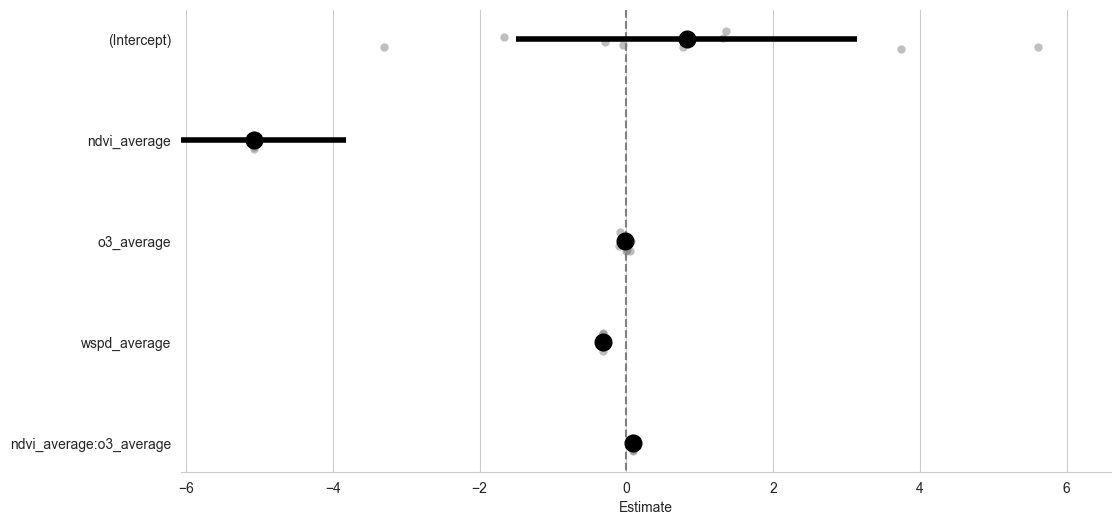

In [174]:
best_model.plot_summary()

### Higher skewness , means that death hive have right skewed distribution (more positive value)

Let's check these distribution of average (which is an aggregate but should show similar pattern)

<Axes: xlabel='aqhi_average_og', ylabel='Density'>

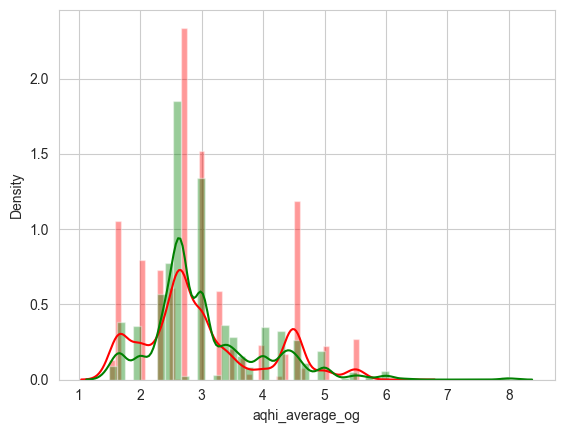

In [175]:
sns.distplot(data.loc[data['death_next_season']]['aqhi_average_og'], label="Death", color="red")
sns.distplot(data.loc[~data['death_next_season']]['aqhi_average_og'], label="Alive",color="green")

### Shallow learning approach 

In [176]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 40,60]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 40,60]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [177]:
features = ['aqhi_average_og','tavg_average_og','tavg_max','tavg_skew'
            ,'wspd_average_og','wspd_skew','wspd_max','ndvi_skew','ndvi_max','ndvi_average'
            ,'prcp_average_og','prcp_skew','prcp_max']
data.season.value_counts()

season
2022    24326
2021     5942
Name: count, dtype: int64

In [178]:

mx=StandardScaler()

gr = pd.get_dummies(data['region'])
X = data.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X.fillna(0,inplace=True)
X = X[features]
X = pd.concat([X,gr],axis=1)

data['death_next_season'] = data['death_next_season'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis=1).tolist(),dtype=[('cens', '?'), ('time', '<f8')]),
    test_size=0.15,
    random_state=8,
)

X_train = mx.fit_transform(X_train)
X_test = mx.transform(X_test)



In [ ]:

rf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=5,
    cv=3,
    verbose=1,
    random_state=8,
    n_jobs=4,
)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
rsf = rf_random.best_estimator_

In [ ]:
print("SCORE")
print(rsf.score(X_test,y_test))

sns.displot(rsf.predict(X_test))

### Evalutate

In [ ]:
va_times = np.arange(220, 550, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)


In [ ]:
plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.savefig("ROC.png")
plt.grid(True)

### FEature importance

In [ ]:
result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=8
)

pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X.columns
).sort_values(by="importances_mean", ascending=False)

### Basic simulation

In [ ]:
def process(X, factor):
    X_copy = X.copy()
    X_copy[['aqhi_average']] = X[['aqhi_average']] * factor
    #data = mx.transform(data)
    return X_copy
    

In [ ]:
def avg_surv_func(feat):
    surv = rsf.predict_survival_function(feat, return_array=True)
    return np.mean(surv,axis=0)

In [ ]:
preds = avg_surv_func(process(X, 1))
preds2 = avg_surv_func(process(X, 1.1))
preds3 = avg_surv_func(process(X, 1.5))
preds4 = avg_surv_func(process(X, 2))
preds8 = avg_surv_func(process(X, 4))


In [ ]:
predictions = np.stack([preds,preds2,preds3,preds4,preds8],axis=1,dtype=np.float32).flatten()
predictions.shape

In [ ]:
temps = []
for _ in [1.0,1.1,1.5,2.0,4.0]:
    temps.append([i for i in range(len(preds))])

In [ ]:
temps = np.stack(temps,axis=1).flatten()
temps.shape

In [ ]:
factor = []
for ii in [1.0,1.1,1.5,2.0,4.0]:
    f = []
    for _ in range(len(preds)):
        f.append([f"{ii}x"])
    factor.append(f)
factor = np.stack(factor,axis=1).flatten()
factor.shape

In [ ]:
results = pd.DataFrame({"Probabilité de survie":predictions,"Temps":temps, "Facteur":factor})
results.head()

In [ ]:
LANG = "EN"
title = {"FR":"Fonction de survie attendue dans des simulations \n d'intensification de mauvaise qualité de l'air",
         "EN":"Expected survival function for different simulations with varying air quality"}
xaxe = {"FR": "Temps (en jours)","EN":"Time (days)"}
yaxe = {"FR": "Probabilité de survie", "EN":"Probability of survival"}


sns.lineplot(x=results['Temps'], y=results['Probabilité de survie'], hue=results["Facteur"], linewidth=3, alpha=0.85, linestyle="solid")
plt.ylabel(yaxe[LANG])
plt.xlabel(xaxe[LANG])
plt.title(title[LANG])
plt.legend()
plt.grid(True)
plt.savefig(f"figure-2-{LANG}.png")

### Pred on 2023 true value

### Conclusion and next steps 